# Hello CNN Xception Style Dogs vs. Cats Classifier

Build an Xception architecture style Dogs vs. Cats classifier using a small dataset from Kaggle.  Should work better than a vanilla Sequential CNN.

In [7]:
# Prerequisites
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers

### Download Data from Kaggle

https://www.kaggle.com/c/dogs-vs-cats/data

This dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543 MB (compressed). For this example create a new dataset with three subsets: a training set with 1,000 samples of each class, a validation set with 500 samples of each class, and a test set with 1,000 samples of each class.

In [8]:
import os, shutil, pathlib

# Point this to where the training data from Kaggle was downloaded and extracted
download_dir = pathlib.Path("/Datasets/Kaggle_dogs_vs_cats/train")
# Create small dataset under the project directory
small_data_dir = pathlib.Path("data/dogs_vs_cats_small")

def make_subset(subset_name, start_idx, end_idx):
    for category in ("cat", "dog"):
        dir = small_data_dir / subset_name / category
        os.makedirs(dir, exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_idx, end_idx)]
        for fname in fnames:
            shutil.copyfile(src=download_dir / fname, dst=dir / fname)

make_subset("train", start_idx=0, end_idx=1000)
make_subset("validation", start_idx=1000, end_idx=1500)
make_subset("test", start_idx=1500, end_idx=2500)

### Data Preprocessing

- Read the picture files.
- Decode the JPEG content to RGB grids of pixels
- Convert pixel grids into floating-point tensors.
- Resize them to 180x180 size
- Pack them into batches of 32 images

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory

train_ds = image_dataset_from_directory(
    small_data_dir / "train",
    image_size=(180, 180),
    batch_size=32
)
validation_ds = image_dataset_from_directory(
    small_data_dir / "validation",
    image_size=(180, 180),
    batch_size=32
)
test_ds = image_dataset_from_directory(
    small_data_dir / "test",
    image_size=(180, 180),
    batch_size=32
)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [10]:
# Check that data shapes are correct
for data_batch, labels_batch in train_ds:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


### Build the CNN

In [11]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2)
    ]
)

In [14]:
inputs = keras.Input(shape=(180, 180, 3))

x = data_augmentation(inputs)

x = layers.Rescaling(1./255)(x)  # Scale to range [0, 1]
# Convolution Layers
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
    residual = x

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.SeparableConv2D(size, 3, padding="same", use_bias=False)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

    residual = layers.Conv2D(size, 1, strides=2, padding="same", use_bias=False)(residual)

    x = layers.add([x, residual])


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
# Fully Connected Layer 
outputs = layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [15]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 180, 180,  │          0 │ input_layer_3[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 180, 180,  │          0 │ sequential[2][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 176, 176,  │      2,400 │ rescaling_2[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_2  │ (None, 176, 176,  │      1,312 │ activation_3[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 176, 176,  │        128 │ separable_conv2d… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 176, 176,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_3  │ (None, 176, 176,  │      1,312 │ activation_4[0][… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 88, 88,    │          0 │ separable_conv2d… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 88, 88,    │      1,024 │ conv2d_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 88, 88,    │          0 │ max_pooling2d_1[… │
│                     │ 32)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        128 │ add_1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 88, 88,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv2d_4  │ (None, 88, 88,    │      2,336 │ activation_5[0][… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 88, 88,    │        256 │ separable_conv2d

 Total params: 721,857 (2.75 MB)

 Trainable params: 718,849 (2.74 MB)

 Non-trainable params: 3,008 (11.75 KB)

### Compile model  

In [16]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Build the model

In [ ]:
history = model.fit(train_ds, epochs=30, validation_data=validation_ds)

### Plot Training and Validation Accuracy

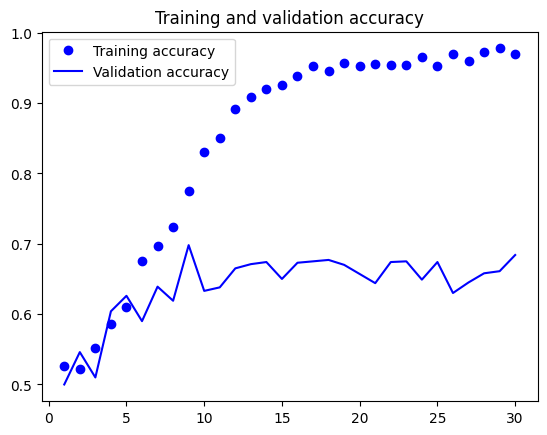

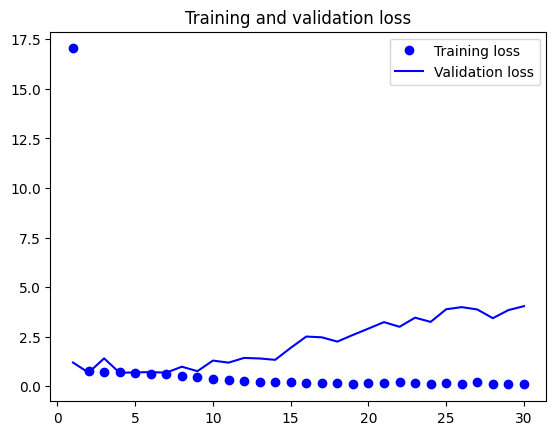

In [13]:
accy = history.history["accuracy"]
val_accy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accy) + 1)
plt.plot(epochs, accy, "bo", label="Training accuracy")
plt.plot(epochs, val_accy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Evaluate with test set

In [14]:
test_model = keras.models.load_model("dogs_vs_cats.keras")
test_loss, test_acc = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.5542 - loss: 0.6855
Test accuracy: 0.552


Just barely better than a 50% Baseline of random guesses.  Model overfit due to the small number of training samples.

## Try to reduce Overfitting with Regularization

### Add Data Augmentation

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Plot examples of augmentation

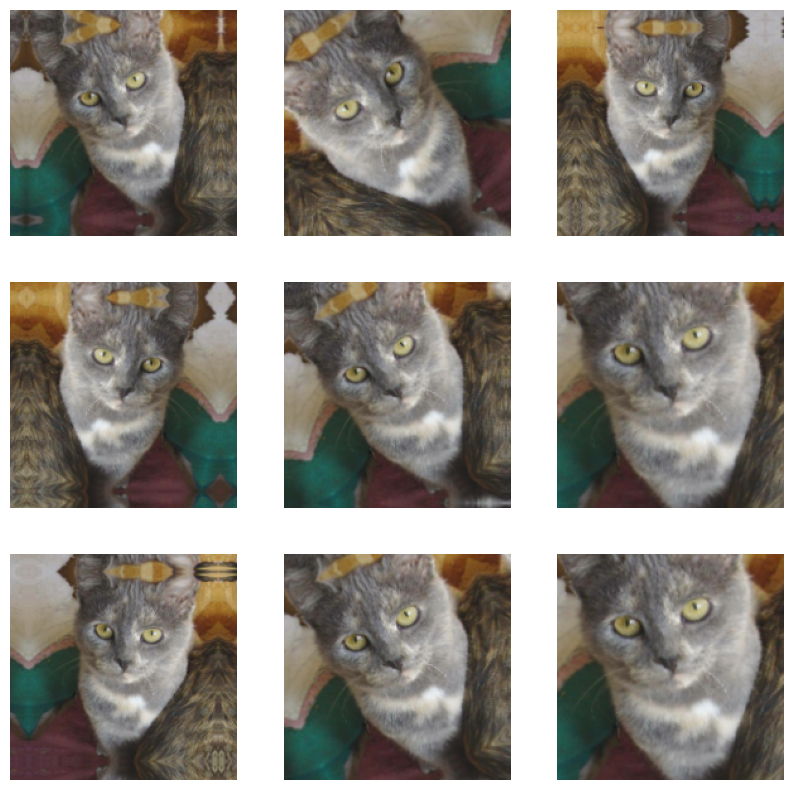

In [16]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Build a new model with data augmentation and dropout

In [17]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [18]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        12,545 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

### Compile model

In [19]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

### Train model with regularization

In [20]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="dogs_vs_cats_with_regularization.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(train_ds, epochs=15, validation_data=validation_ds, callbacks=callbacks)

Epoch 1/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - accuracy: 0.4753 - loss: 0.7382 - val_accuracy: 0.5360 - val_loss: 0.6929
Epoch 2/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 226ms/step - accuracy: 0.5060 - loss: 0.6936 - val_accuracy: 0.5000 - val_loss: 0.6920
Epoch 3/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 224ms/step - accuracy: 0.5495 - loss: 0.6899 - val_accuracy: 0.6150 - val_loss: 0.6716
Epoch 4/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 219ms/step - accuracy: 0.5496 - loss: 0.6829 - val_accuracy: 0.6060 - val_loss: 0.6580
Epoch 5/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.5890 - loss: 0.6740 - val_accuracy: 0.5310 - val_loss: 0.8437
Epoch 6/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 223ms/step - accuracy: 0.5949 - loss: 0.6578 - val_accuracy: 0.5960 - val_loss: 0.6488
Epoch 7/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 221ms/step - accuracy: 0.6290 - loss: 0.6456 - val_accuracy: 0.6520 - val_loss: 0.6154
Epoch 8/15
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 222ms/step - accuracy: 0.6654 - loss: 0.6185 - val_accu

### Evaluate Regularized Model with Test Set

In [21]:
test_model = keras.models.load_model("dogs_vs_cats_with_regularization.keras")
test_loss, test_accy = test_model.evaluate(test_ds)
print(f"Test accuracy: {test_accy:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.7310 - loss: 0.5295
Test accuracy: 0.719


Improved from 55% to 72%

## Leverage a pretrained model (VGG16)

### Get VGG16 model (prepackaged with Keras)

In [36]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet", include_top=False, input_shape=(180, 180, 3)
)

In [37]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### Extract VGG16 features and corresponding labels

In [25]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        prepocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(prepocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels = get_features_and_labels(train_ds)
val_features, val_labels = get_features_and_labels(validation_ds)
test_features, test_labels = get_features_and_labels(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 947ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 769ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 733ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 735ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 722ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 728ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 740ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [27]:
print(f"Train features shape: {train_features.shape}, train labels shape: {train_labels.shape}")
print(f"Validation features shape: {val_features.shape}, validation labels shape: {val_labels.shape}")
print(f"Test features shape: {test_features.shape}, test labels shape: {test_labels.shape}")

Train features shape: (2000, 5, 5, 512), train labels shape: (2000,)
Validation features shape: (1000, 5, 5, 512), validation labels shape: (1000,)
Test features shape: (2000, 5, 5, 512), test labels shape: (2000,)


### Build Dense connected classifier 

In [29]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs)



In [30]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,277,313 (12.50 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

### Train model with data and labels VGG16

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="dogs_vs_cats_feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]

history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8892 - loss: 13.3779 - val_accuracy: 0.9630 - val_loss: 4.0136
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9749 - loss: 3.8329 - val_accuracy: 0.9760 - val_loss: 3.4928
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9837 - loss: 1.8622 - val_accuracy: 0.9770 - val_loss: 3.4647
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9898 - loss: 0.7068 - val_accuracy: 0.9810 - val_loss: 2.7749
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9958 - loss: 0.6267 - val_accuracy: 0.9800 - val_loss: 3.4540
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9954 - loss: 0.3764 - val_accuracy: 0.9720 - val_loss: 6.3568
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9903 - loss: 1.0327 - val_accuracy: 0.9790 - val_loss: 3.9877
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 1.0000 - loss: 1.2112e-09 - val_accuracy: 0.979

### Plot Accuracy and Loss

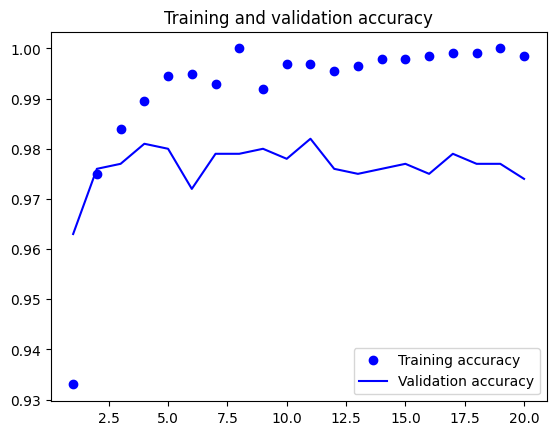

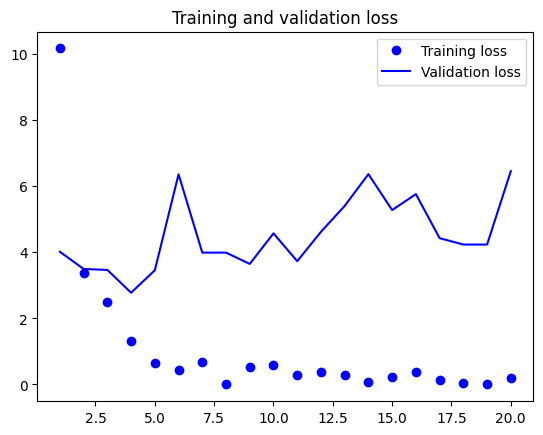

In [32]:
accy = history.history["accuracy"]
val_accy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accy) + 1)
plt.plot(epochs, accy, "bo", label="Training accuracy")
plt.plot(epochs, val_accy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

### Evaluate the model

In [34]:
test_model = keras.models.load_model("dogs_vs_cats_feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9746 - loss: 4.0641   
Test accuracy: 0.970


97% Test Accuracy!

## Feature Extraction together With Data Augmentation

Add dataaugmentation, freeze the convolutional base layer to prevent it from being updated during training

In [8]:
conv_base = keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)

conv_base.trainable = False

In [39]:
conv_base.trainable = True
print("# of trainable weights before freezing:", len(conv_base.trainable_weights))

# of trainable weights before freezing: 26


In [40]:
conv_base.trainable = False
print("# of trainable weights after freezing:", len(conv_base.trainable_weights))

# of trainable weights after freezing: 0


### Build model with data augmentation and dropout

In [12]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)

### Compile model

In [42]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="dogs_vs_cats_vgg16_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_ds,
    epochs=50,
    validation_data=validation_ds,
    callbacks=callbacks)

## Fine-tune a pretrained model

In [9]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

### Freeze layers up to the 4th from the end

In [10]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

### Fine-tune model

In [13]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])


In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="dogs_vs_cats_vgg16_fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=validation_ds,
    callbacks=callbacks)